In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
imagergb = cv2.imread('images/nb.jpg')
img = cv2.cvtColor(imagergb,cv2.COLOR_BGR2RGB)
print(img.shape)

(4000, 3000, 3)


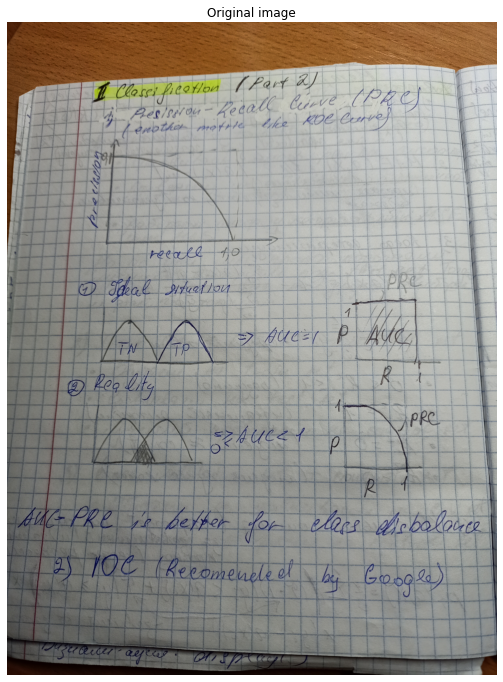

In [3]:
plt.figure(figsize=(9,12))
plt.clf()
plt.axis("off")
plt.title("Original image")
plt.imshow(img)

In [4]:
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

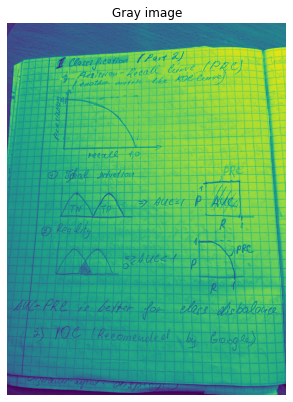

In [5]:
plt.figure(figsize=(5,10))
plt.axis("off")
plt.title("Gray image")
plt.imshow(gray)

In [6]:
low_sigma = cv2.GaussianBlur(img,(1,1),0)
high_sigma = cv2.GaussianBlur(img,(3,3),0)

# Calculate the DoG by subtracting
dog = low_sigma - high_sigma

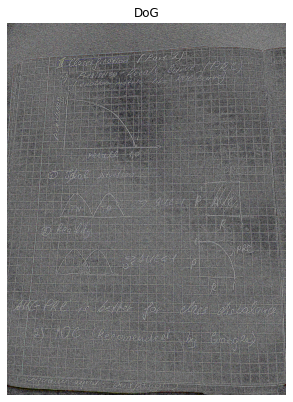

In [7]:
plt.figure(figsize=(5,10))
plt.clf()
plt.axis("off")
plt.title("DoG")
plt.imshow(dog)

In [8]:
edges = cv2.Canny(gray, 70, 80, apertureSize=3, L2gradient=True)

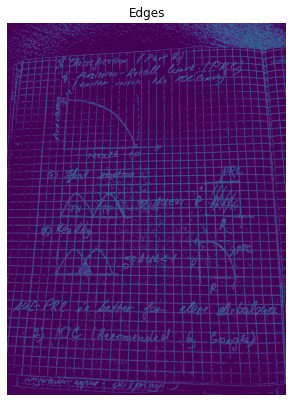

In [9]:
plt.figure(figsize=(5,10))
plt.clf()
plt.axis("off")
plt.title("Edges")
plt.imshow(edges)

In [10]:
lines = cv2.HoughLines(edges, 1, np.pi/360, 550,)

horizontal_lines = []
vertical_lines = []
img_copy = img.copy()

for i, _ in enumerate(lines):
    for rho, theta in lines[i]:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 4000*(-b))
        y1 = int(y0 + 4000*(a))
        x2 = int(x0 - 4000*(-b))
        y2 = int(y0 - 4000*(a))
        if abs(x1-x2) > 1000:
            cv2.line(img_copy,(x1,y1),(x2,y2),(255,0,0),2)
            horizontal_lines.append(((x1, y1, 1), (x2, y2, 1)))
        else:
            cv2.line(img_copy,(x1,y1),(x2,y2),(0,255,0),2)
            vertical_lines.append(((x1, y1, 1), (x2, y2, 1)))

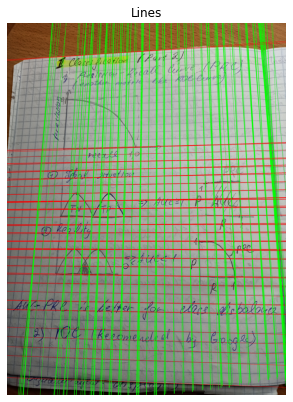

In [11]:
plt.figure(figsize=(5,10))
plt.clf()
plt.axis("off")
plt.title("Lines")
plt.imshow(img_copy)

((-3962, 682, 1), (4018, 123, 1))
((167, 4025, 1), (795, -3949, 1))
((-4130, 3668, 1), (3864, 3947, 1))
((2471, -4231, 1), (3168, 3738, 1))


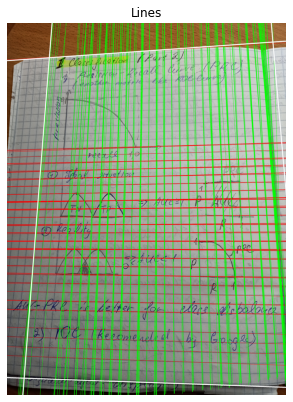

In [19]:
left = vertical_lines[np.array(vertical_lines)[:,1, 0].argmin()]
right = vertical_lines[np.array(vertical_lines)[:,1, 0].argmax()]
top = horizontal_lines[np.array(horizontal_lines)[:,1, 1].argmin()]
bottom = horizontal_lines[np.array(horizontal_lines)[:,1, 1].argmax()]

for line in [top, left, bottom, right]:
    print(line)
    cv2.line(img_copy,line[0][:2], line[1][:2],(255,255,255), 10)
    
plt.figure(figsize=(5,10))
plt.clf()
plt.axis("off")
plt.title("Lines")
plt.imshow(img_copy)

In [13]:
#find sheet corners

line_coef_list = list(map(lambda x: np.cross(x[0], x[1]), [top, left, bottom, right]))

cross_points = []
for i, coefs in enumerate(line_coef_list):
    try:
        cross_points.append((np.cross(coefs, line_coef_list[i+1])/np.cross(coefs, line_coef_list[i+1])[2])[:2])
    except IndexError:
        cross_points.append((np.cross(coefs, line_coef_list[0])/np.cross(coefs, line_coef_list[0])[2])[:2])
        
cross_points

[array([454.64720863, 372.61330957]),
 array([ 183.26012416, 3818.53785022]),
 array([3184.20482133, 3923.27434891]),
 array([2858.91944229,  204.19373832])]

In [14]:
# sqrt((x1-x0)^2 + (y1-y0)^2), distance between corner points
def get_border_length(point1, point2):
    return np.linalg.norm(point2-point1)


#get frame ratio
def get_ratio(point_list):  
    length_list = []
    for i, point in enumerate(point_list):
        try:
            length_list.append(get_border_length(point, point_list[i+1]))
        except IndexError:
            length_list.append(get_border_length(point, point_list[0]))
    #get max x and y sheet borders
    x_length = max(length_list[1], length_list[3])
    y_length = max(length_list[0], length_list[2])
    #normalize 
    x_length_norm = x_length / max(x_length, y_length)
    y_length_norm = y_length / max(x_length, y_length)
    
    return x_length_norm, y_length_norm

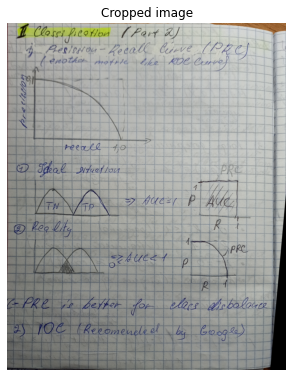

In [15]:
# do Perspective Transform

srcpts = np.float32([cross_points]) 
shape = tuple(map(lambda x: int(max(img.shape)*x), get_ratio(cross_points)))
destpts = np.float32([[0, 0],  [0, shape[1]], shape, [shape[0], 0]]) 
resmatrix = cv2.getPerspectiveTransform(srcpts, destpts)
resultimage = cv2.warpPerspective(img, resmatrix, shape)
plt.figure(figsize=(5,10))
plt.clf()
plt.axis("off")
plt.title("Cropped image")
plt.imshow(resultimage)

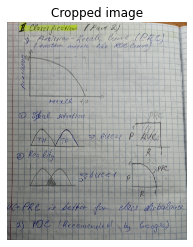

In [18]:
import cv2
import matplotlib.pyplot as plt

from ImgCropper import ImgCropper



image = cv2.imread('images/nb.jpg')
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

cropped_img = ImgCropper().crop_image(image)

plt.axis("off")
plt.title("Cropped image")
plt.imshow(cropped_img)